## Check GPU

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
from sklearn.metrics import classification_report

# Tensorflow
import tensorflow as tf
import tensorflow_addons as tfa

# Keras
from keras import models, layers
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.applications import VGG16

# Warnings
import warnings
warnings.filterwarnings("ignore")

c:\Users\faith\anaconda3\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\faith\anaconda3\Lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.15.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure yo

In [2]:
gpu = tf.config.list_physical_devices('GPU')
gpu

[]

In [3]:
# Access image directory
root_dir = r"C:/Users/faith/Documents/CHEXSCAN/data/dataset"
train_dir = root_dir + "/train_data"
valid_dir = root_dir + "/test_data"

In [4]:
# Acquiring a list of all class names
class_names = os.listdir(train_dir)
print(class_names)

['Normal', 'Pneumonia', 'Tuberculosis']


In [5]:
IMAGE_SIZE = 224
HEIGHT = 224
WIDTH = 224
CHANNELS = 3
BATCH_SIZE = 32
EPOCHS = 25

n_classes = len(class_names)
n_classes

3

## Data Generator

In [6]:
img_size = (IMAGE_SIZE, IMAGE_SIZE)

train_datagen = ImageDataGenerator(
    rescale=1/255.,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range = 0.2,
    horizontal_flip = True,
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 1800 images belonging to 3 classes.


In [7]:
valid_datagen = ImageDataGenerator(rescale=1/255.)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=img_size,
    batch_size=1,
    shuffle=False,
    class_mode='categorical'
)

Found 300 images belonging to 3 classes.


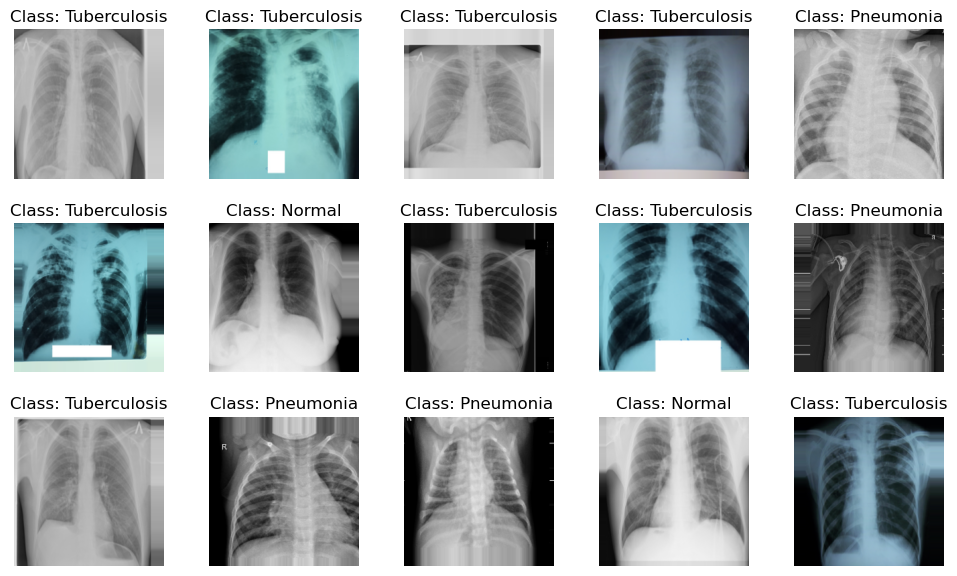

In [8]:
# Get the class indices and names from the train generator
class_indices = train_generator.class_indices
label_to_name = {idx: name for name, idx in class_indices.items()}
samples = train_generator.__next__()  # next fetches the image from the object. Each run gives a new set of images in the training set

images = samples[0]
target = samples[1]

plt.figure(figsize=(12, 12))
for i in range(15):
    plt.subplot(5, 5, i + 1)
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.imshow(images[i])

    # Convert the float target to integer (0 or 1)
    label_idx = tuple(target[i]).index(1)
    class_name = label_to_name[label_idx]

    plt.title(f"Class: {class_name}")
    plt.axis('off')

plt.show()

In [9]:
#Defining a custom callback function to stop training our model when accuracy goes above 99%
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            # self.model.stop_training = False

my_callback = MyCallback()

# #Defining a custom callback function to stop training our model when accuracy goes above 99%
# class MyCallback(tf.keras.callbacks.Callback):
#     def __init__(self, threshold_count):
#         super(MyCallback, self).__init__()
#         self.threshold_count = threshold_count
#         self.consecutive_count = 0

#     def on_epoch_end(self, epoch, logs={}):
#         if logs.get('val_acc') > 0.99:
#             self.consecutive_count += 1
#             if self.consecutive_count >= self.threshold_count:
#                 print("\nReached accuracy threshold 3 times! Terminating training.")
#                 self.model.stop_training = False
#         else:
#             self.consecutive_count = 0

# # Define the callback with the threshold count
# my_callback = MyCallback(threshold_count=3)

#ReduceLROnPlateau to stabilize the training process of the model
rop_callback = ReduceLROnPlateau(monitor="val_loss",
                                 patience=10)

# EarlyStopping callback to stop training if val_loss does not improve after n epochs
earlystop_cb = EarlyStopping(monitor='val_loss',
                             patience=10,
                             restore_best_weights=True)

checkpoint_cb = ModelCheckpoint('model.h5', save_best_only=True)

# VGG16

In [10]:
input_layer=layers.Input(shape=(IMAGE_SIZE,IMAGE_SIZE,CHANNELS))

model_vgg16 = VGG16(weights='imagenet',
                    input_tensor=input_layer,
                    include_top=False)

last_layer=model_vgg16.output

flatten=layers.Flatten()(last_layer)

output_layer=layers.Dense(n_classes,activation='softmax')(flatten)

model_vgg16=models.Model(inputs=input_layer,outputs=output_layer)

# Making all the layers intrainable except the last layer
for layer in model_vgg16.layers[:-1]:
    layer.trainable=False

In [11]:
METRICS = [tf.keras.metrics.BinaryAccuracy(name='acc'),
           tfa.metrics.F1Score(num_classes=n_classes)]

# CALLBACKS = [my_callback, rop_callback, earlystop_cb] # Removed due to stopping condition 
CALLBACKS = [rop_callback]


In [12]:
model_vgg16.compile(optimizer='adam',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)
# model_vgg16.summary()

In [13]:
history_vgg = model_vgg16.fit(
    train_generator,
    batch_size=BATCH_SIZE,
    verbose=True,
    validation_data=valid_generator,
    callbacks=CALLBACKS,
    epochs=EPOCHS
)

Epoch 1/25

57/57 [==============================] - 76s 1s/step - loss: 0.5157 - acc: 0.8783 - f1_score: 0.8084 - val_loss: 0.2293 - val_acc: 0.9467 - val_f1_score: 0.9189 - lr: 0.0010
Epoch 2/25
57/57 [==============================] - 77s 1s/step - loss: 0.2914 - acc: 0.9354 - f1_score: 0.9004 - val_loss: 0.1899 - val_acc: 0.9556 - val_f1_score: 0.9326 - lr: 0.0010
Epoch 3/25
57/57 [==============================] - 75s 1s/step - loss: 0.2463 - acc: 0.9441 - f1_score: 0.9167 - val_loss: 0.2410 - val_acc: 0.9556 - val_f1_score: 0.9321 - lr: 0.0010
Epoch 4/25
57/57 [==============================] - 75s 1s/step - loss: 0.2313 - acc: 0.9476 - f1_score: 0.9194 - val_loss: 0.1694 - val_acc: 0.9556 - val_f1_score: 0.9328 - lr: 0.0010
Epoch 5/25
57/57 [==============================] - 77s 1s/step - loss: 0.3791 - acc: 0.9181 - f1_score: 0.8765 - val_loss: 0.6193 - val_acc: 0.9378 - val_f1_score: 0.9025 - lr: 0.0010
Epoch 6/25
57/57 [==============================] - 77s 1s/step - loss: 0.

In [14]:
predictions = model_vgg16.predict(valid_generator)

# Obtain the true labels from the test_generator
true_labels = valid_generator.classes

# Generate the classification report
report = classification_report(true_labels, predictions.argmax(axis=1), target_names=class_names)
print(report)

300/300 [==============================] - 15s 48ms/step
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       100
   Pneumonia       0.85      0.99      0.91       100
Tuberculosis       0.99      0.82      0.90       100

    accuracy                           0.94       300
   macro avg       0.94      0.94      0.94       300
weighted avg       0.94      0.94      0.94       300



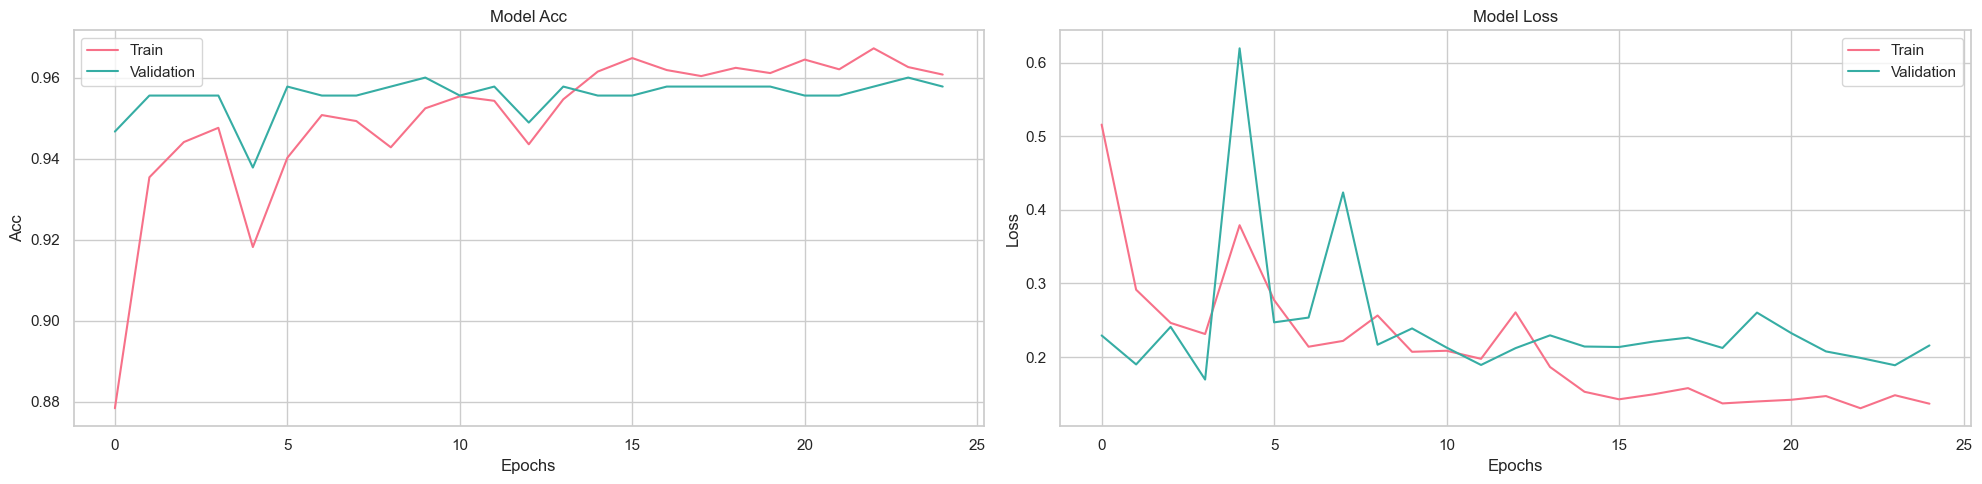

In [15]:
sns.set(style="whitegrid", rc={"axes.grid": True})

# Create a color palette
palette = sns.color_palette("husl", 2)

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax = ax.ravel()

# Loop through metrics
for i, metric in enumerate(["acc", "loss"]):
    sns.lineplot(x=history_vgg.epoch, y=history_vgg.history[metric], ax=ax[i], label="Train", color=palette[0])
    sns.lineplot(x=history_vgg.epoch, y=history_vgg.history["val_" + metric], ax=ax[i], label="Validation", color=palette[1])

    ax[i].set_title(f"Model {metric.capitalize()}")
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric.capitalize())

    ax[i].legend().set_visible(True)

plt.tight_layout()
plt.show()

In [16]:
from PIL import Image

def predict_image(model, class_names, image_path):
    # Load and preprocess the image
    img = Image.open(image_path)
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE))  # Resize the image
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array.astype('float32') / 255.0  # Normalize the image

    # Predict the class probabilities
    prediction_probs = model.predict(img_array)

    # Round off probabilities to four decimal places
    prediction_probs = np.round(prediction_probs, 4)

    # Map the prediction probabilities to class labels
    predicted_class_index = np.argmax(prediction_probs)
    predicted_class_label = class_names[predicted_class_index]

    return predicted_class_label, prediction_probs

In [17]:
image_path = '/content/drive/My Drive/THESIS/Datasets/Mary/test_data/Normal/Normal-62.png'
predicted_class = predict_image(model_vgg16, class_names, image_path)
predicted_class

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/THESIS/Datasets/Mary/test_data/Normal/Normal-62.png'

In [ ]:
image_path = "/content/drive/My Drive/THESIS/Datasets/Josh's Datasets/Pneumonia-8/person7_bacteria_25.jpeg"
predicted_class = predict_image(model_vgg16, class_names, image_path)
predicted_class

In [ ]:
image_path = "/content/drive/My Drive/THESIS/Datasets/Josh's Datasets/Pneumonia-4/person1_bacteria_1.jpeg"
predicted_class = predict_image(model_vgg16, class_names, image_path)
predicted_class

In [ ]:
image_path = '/content/drive/My Drive/THESIS/Datasets/Mary/test_data/Tuberculosis/Tuberculosis-391.png'
predicted_class = predict_image(model_vgg16, class_names, image_path)
predicted_class